In [1]:
################################################################################
#######################    Time series decomposition    ########################
################################################################################
### Load necessary modules -------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
import numpy as np
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
import unsupervisedtools as UT

In [2]:
# Import data
df = pd.read_csv('Countries.dat', sep=' ')
df.head()

,Country,GDP,ElectricityConsumption,TradeBalance,ExternalDebt,PopulationIncrease,LifeExpectancy,InfantMortality,InternetUsers
1,Afghanistan,0.808025,0.033791,56.824550,1.204340,92.771084,22.074408,75.453351,0.056359
2,Albania,6.937866,6.191515,55.751500,1.672524,40.562249,79.774521,19.195795,0.131505
3,Algeria,13.903594,2.730120,58.652120,4.625188,57.228916,75.535513,19.495401,0.112718
4,Angola,1.365283,0.499132,59.667905,6.117167,66.064257,4.825254,100.000000,0.225437
5,Argentina,34.522151,8.348090,57.031369,24.186137,45.983936,87.508455,7.505913,4.527522


In [3]:
X = df.drop('Country', axis=1) 
y = df[['Country']]

In [4]:
# Preprocessing the values to perform PCA
numeric_features = X.select_dtypes(include=['int64','float64']).columns.values.tolist()
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X=X)

In [5]:
## PCA -----------------------------------------------------------
pca = PCA(n_components=X_transformed.shape[1])
X_pca = pca.fit_transform(X_transformed)
df_pca = pd.DataFrame(data = X_pca, columns = ['PC' + str(n_pca + 1) for n_pca in range(pca.n_components)])

In [6]:
exp_variance = pd.DataFrame(data=pca.explained_variance_ratio_, index = ['PC' + str(n_pca + 1) for n_pca in range(pca.n_components)], columns=['Exp_variance'])
exp_variance['cum_Exp_variance'] = exp_variance['Exp_variance'].cumsum()
exp_variance

,Exp_variance,cum_Exp_variance
PC1,0.532702,0.532702
PC2,0.177932,0.710634
PC3,0.095965,0.806599
PC4,0.078752,0.885351
PC5,0.063791,0.949142
PC6,0.023525,0.972667
PC7,0.015492,0.988160
PC8,0.011840,1.000000


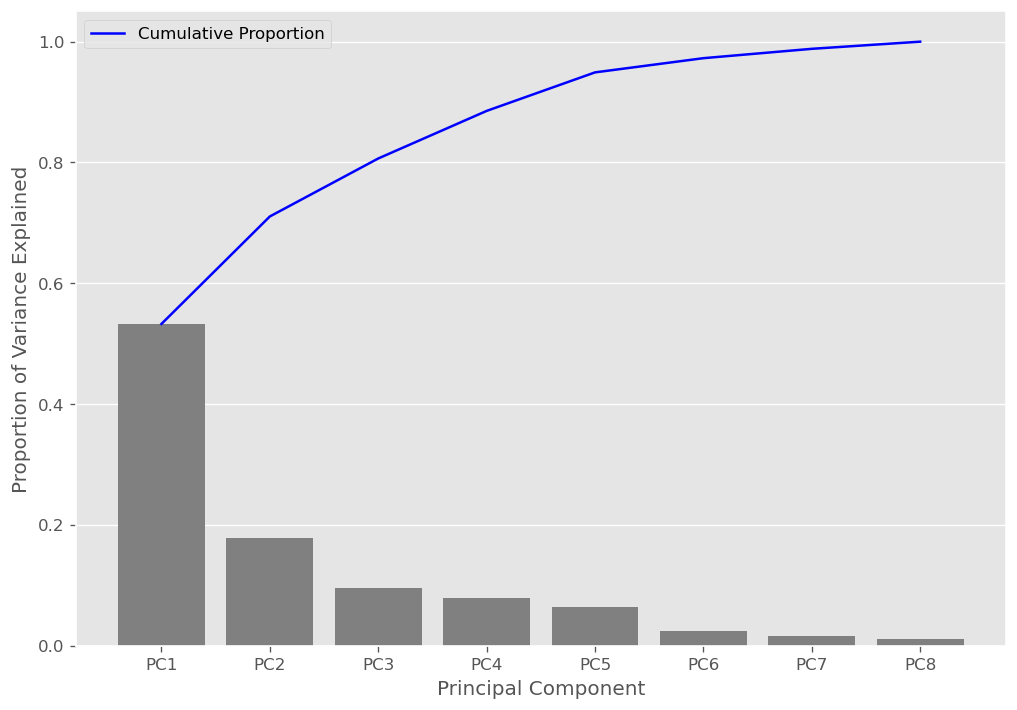

In [7]:
sns.barplot(data=exp_variance, x=exp_variance.index, y='Exp_variance', color='gray')
sns.lineplot(data=exp_variance, x=exp_variance.index, y='cum_Exp_variance', color='blue', label='Cumulative Proportion')
plt.gca().set_ylabel('Proportion of Variance Explained')
plt.gca().set_xlabel('Principal Component')
plt.legend()
plt.show()

In [8]:
# Print the PCs
loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), columns=['PC' + str(pca + 1) for pca in range(pca.n_components)], index=numeric_features)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
GDP,0.912467,0.033529,-0.245906,-0.144062,-0.090099,0.051263,-0.280457,0.057844
ElectricityConsumption,0.859669,0.251464,-0.285456,0.096476,-0.032668,0.302570,0.144621,-0.033229
TradeBalance,0.281239,0.772230,0.169572,0.539431,0.039554,-0.088477,-0.052203,0.019999
ExternalDebt,0.610482,0.406753,0.291760,-0.416524,0.458400,-0.014339,0.024258,-0.003855
PopulationIncrease,-0.469235,0.663879,0.126705,-0.352539,-0.451110,0.017040,0.003597,-0.051326
LifeExpectancy,0.815121,-0.232837,0.423729,-0.011194,-0.254320,-0.008608,0.086658,0.192673
InfantMortality,-0.824945,0.328869,-0.379245,-0.086857,0.125994,0.012797,0.039882,0.223616
InternetUsers,0.840149,0.071818,-0.422328,-0.091489,-0.096541,-0.294806,0.113558,-0.028745


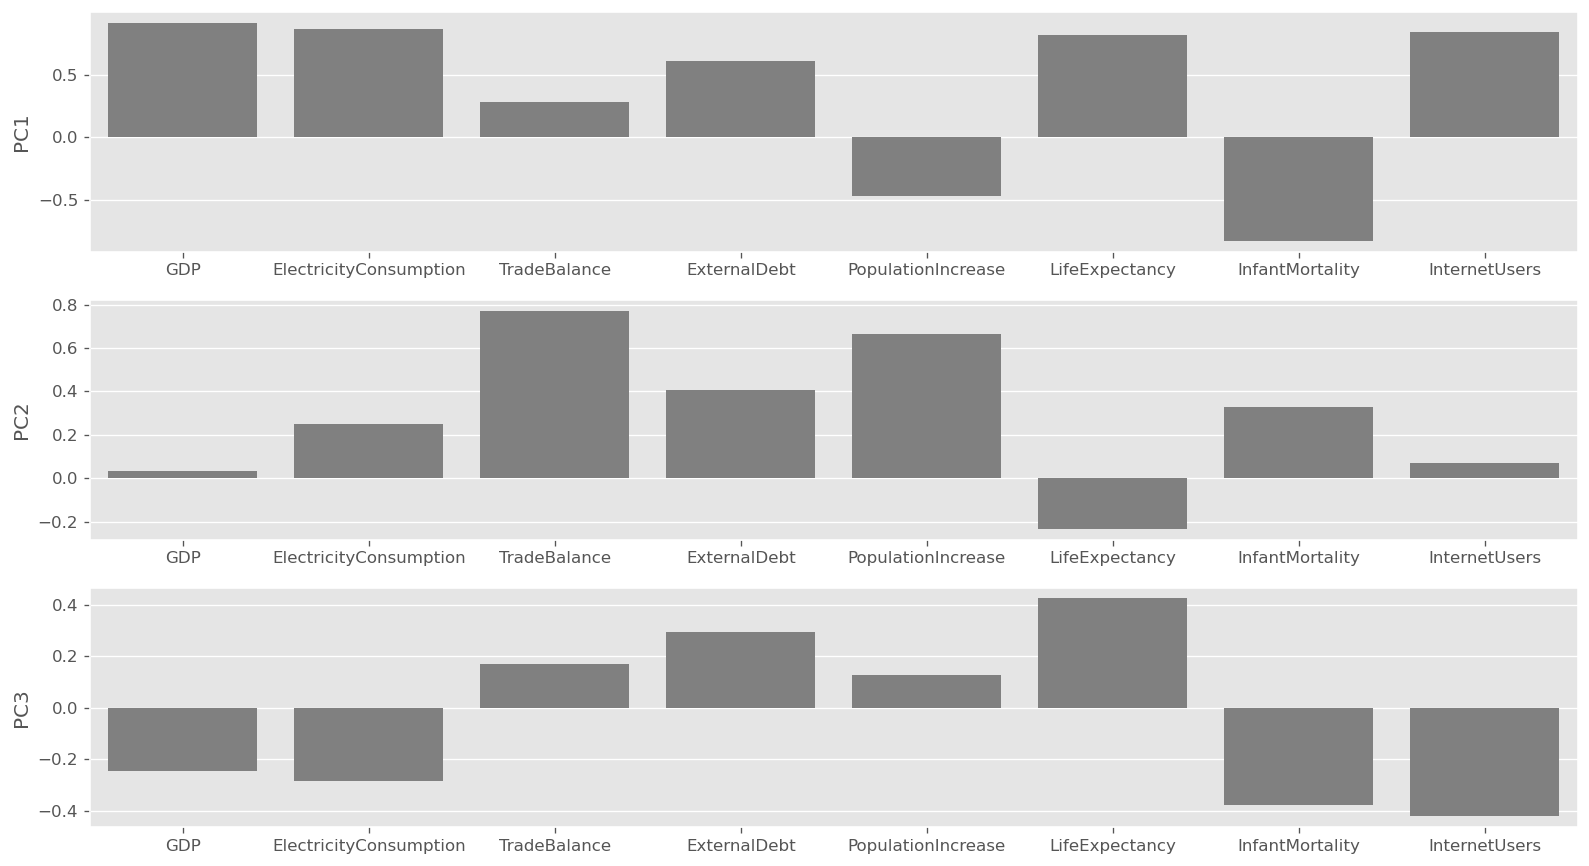

In [9]:
# Plot the 3 first PCs
# fig, axes = plt.subplots(loadings.shape[1], 1, figsize=(16,9))
fig, axes = plt.subplots(3, 1, figsize=(16,9))
PC = 0
for ax in axes.ravel():
    sns.barplot(data=loadings, x=loadings.index, y=loadings.columns.values.tolist()[PC], color='gray', ax=ax)
    PC += 1

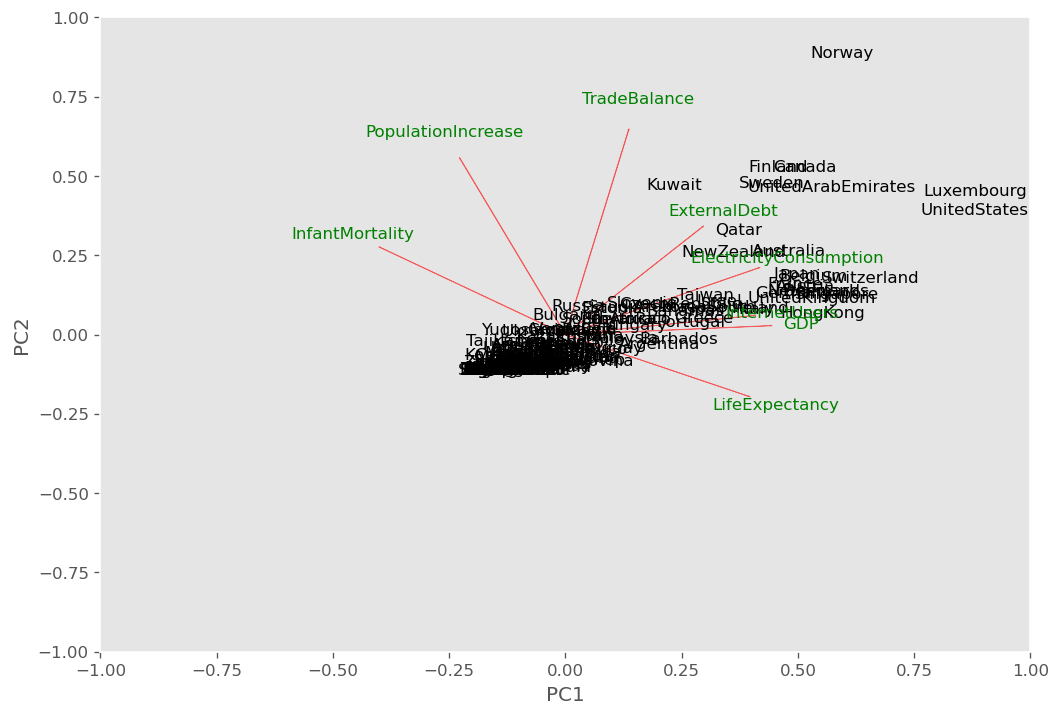

In [10]:
UT.biplot(X_transformed[:,0:2], np.transpose(pca.components_[0:2, :]), y, labels=X.columns.values.tolist())

In [11]:
# Reconstruction using PCA
X_projected = pca.inverse_transform(X_pca)

# Revert scaling
X_projected_unscaled = pd.DataFrame(scaler.inverse_transform(X_projected), columns=X.columns.values.tolist())
# Error of the reconstruction
loss = ((X - X_projected_unscaled) ** 2).mean()
print('Reconstruction error:\n', loss)

Reconstruction error:
 GDP                       1068.683329
ElectricityConsumption     524.223430
TradeBalance               149.213130
ExternalDebt               356.985534
PopulationIncrease        1039.787510
LifeExpectancy            1178.894765
InfantMortality            782.502370
InternetUsers             1099.120958
dtype: float64


In [12]:
## ICA -----------------------------------------------------------
ica = FastICA(n_components=X_transformed.shape[1])
X_ica = ica.fit_transform(X_transformed)
A_ = ica.mixing_  # Get estimated mixing matrix
df_ica = pd.DataFrame(data = X_ica, columns = ['IC' + str(n_pca + 1) for n_pca in range(ica.n_components)])

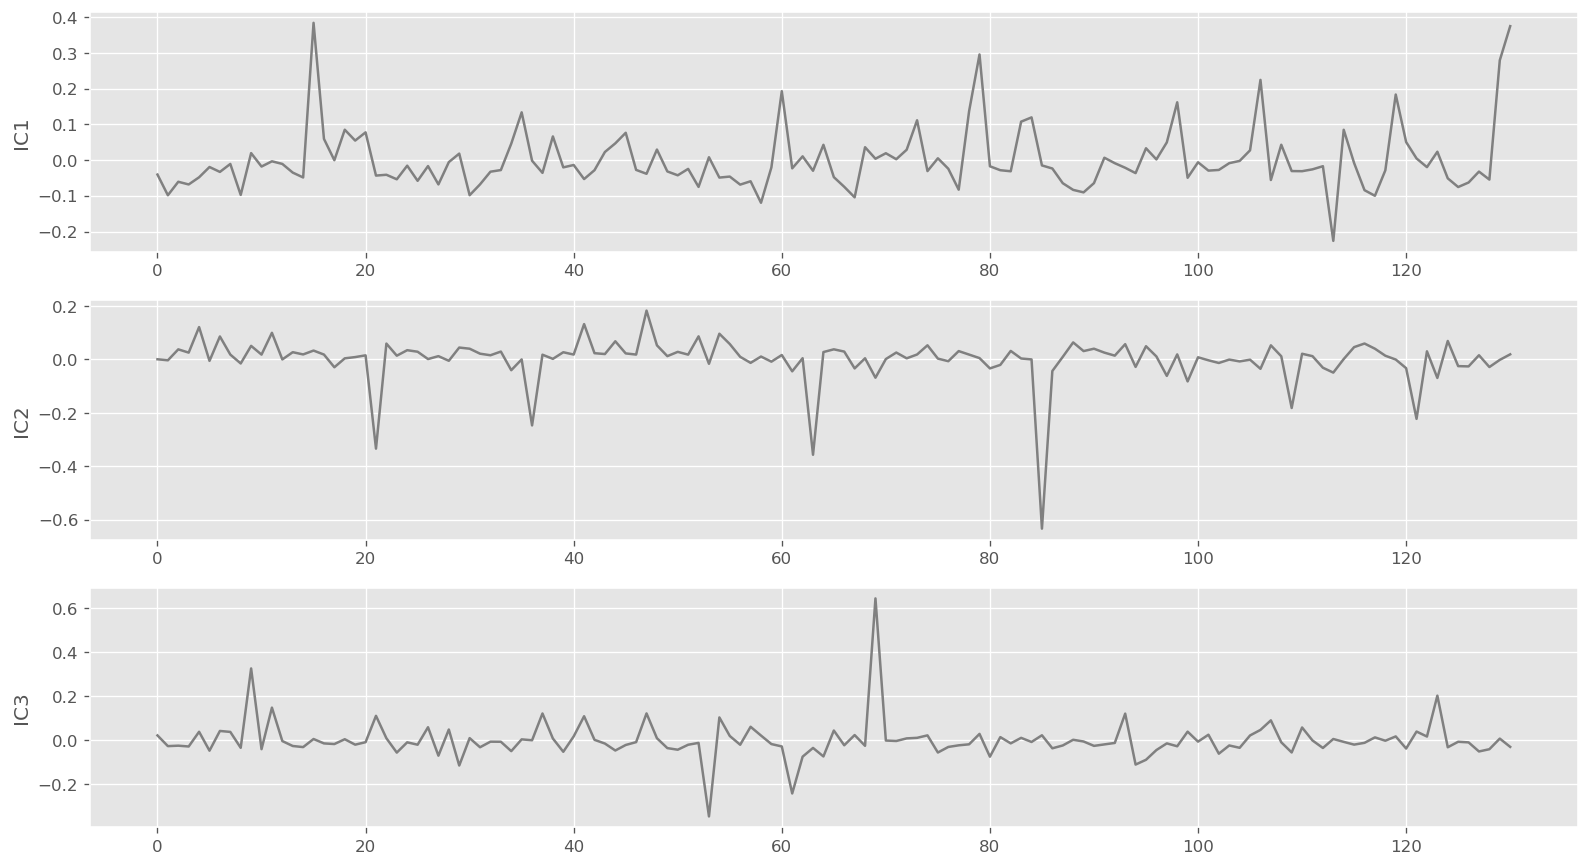

In [14]:
# Plot the 3 first ICs
# fig, axes = plt.subplots(loadings.shape[1], 1, figsize=(16,9))
fig, axes = plt.subplots(3, 1, figsize=(16,9))
IC = 0
for ax in axes.ravel():
    sns.lineplot(data=df_ica, x=df_ica.index, y=df_ica.columns.values.tolist()[IC], color='gray', ax=ax)
    IC += 1

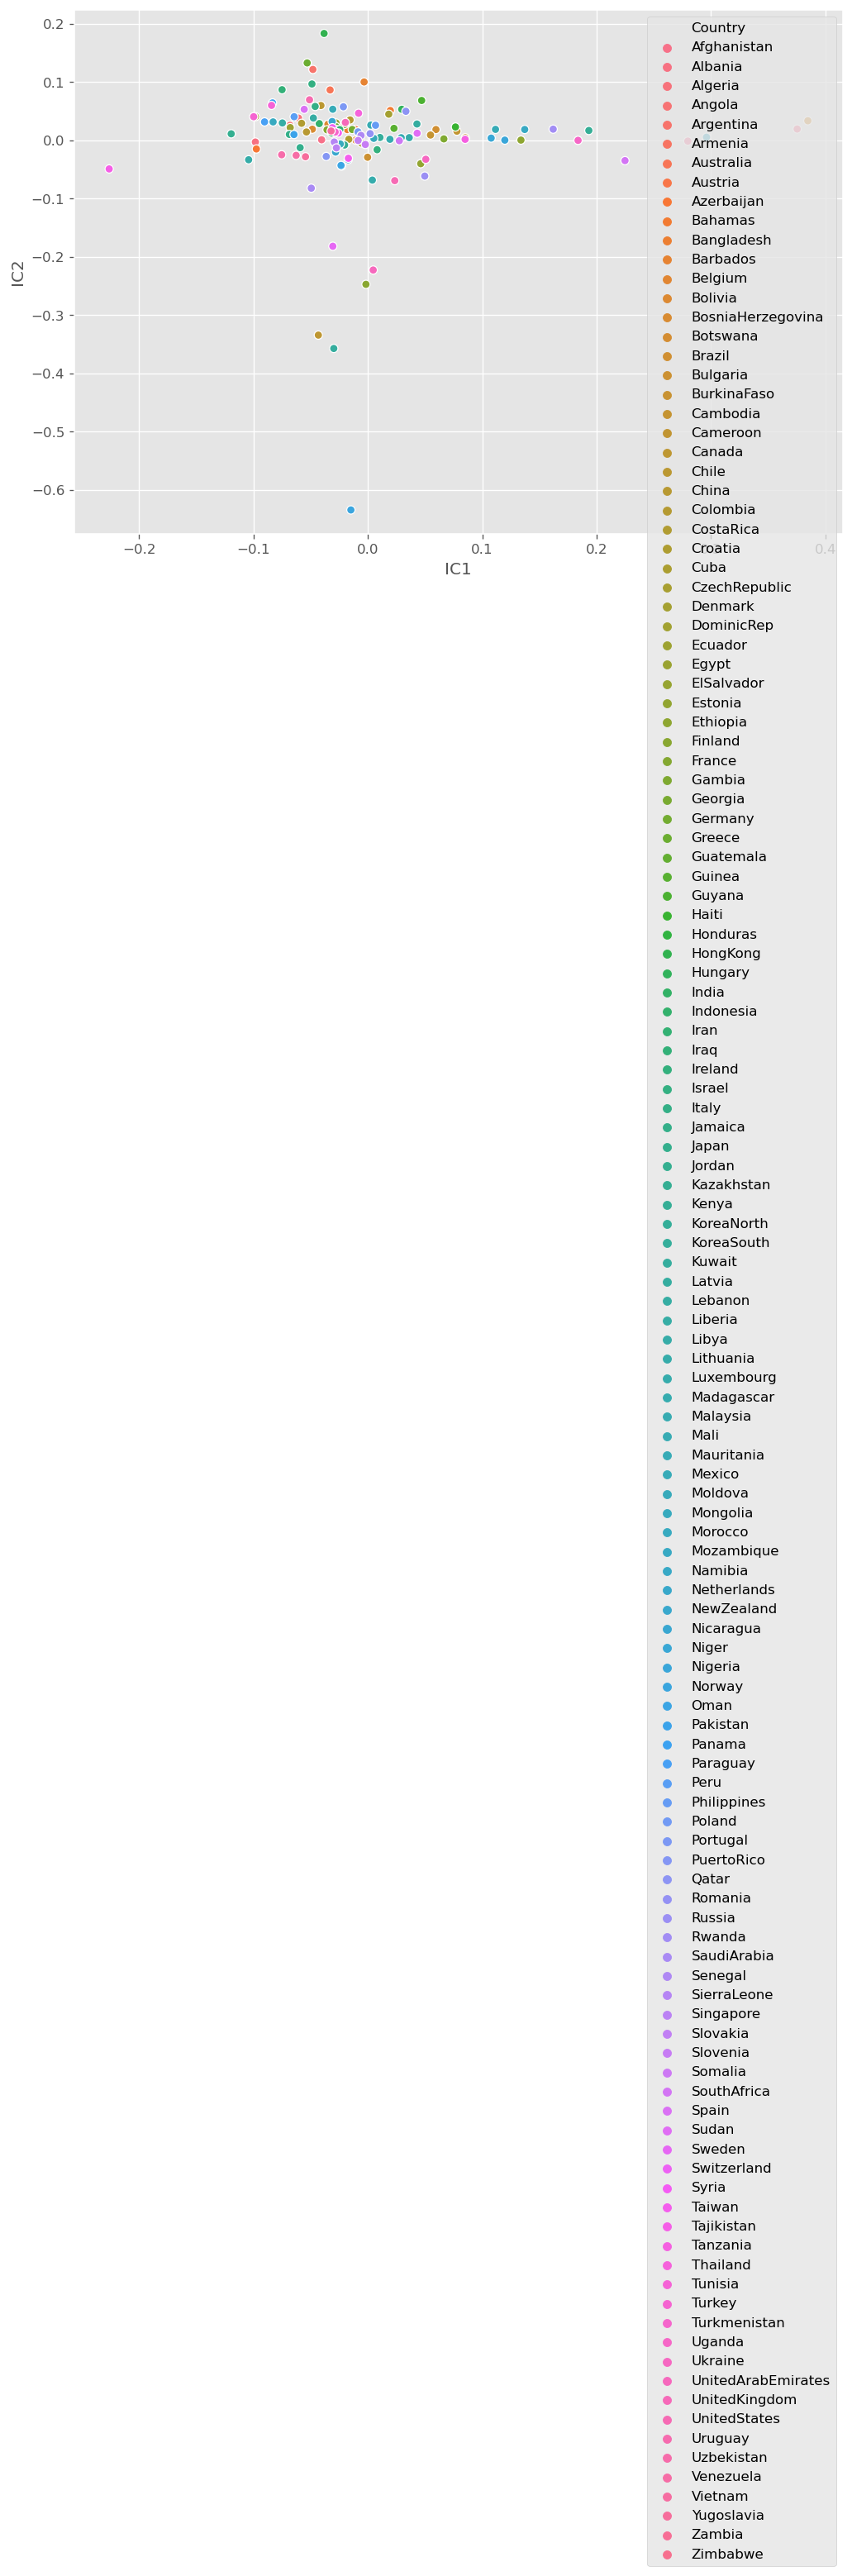

In [18]:
df_ica['Country'] = y.values
sns.scatterplot(data=df_ica, x='IC1', y='IC2', hue='Country')
plt.show()